# End-to-end Model evaluation
In this notebook we are performing an end-to-end evaluation of our model by checking two methods.

In [550]:
# automatically show plots inside the notebook
%matplotlib inline  

# reload all modules before executing code
%load_ext autoreload
%autoreload 2 

import numpy as np
import pickle
import importlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau

from DB.database import Database, get_data, get_entities, get_matrices
from DB.model import *
import DB.model
import src.preprocessing as pre
import src.mc as mc
import src.gr_recommender as gr
import src.sc as sc
from scipy.stats import kendalltau
import src.MF as MF
import src.Solver as Solver
import src.preprocessing as pre
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'src.gr_recommender' from '/home/gaoni/ml-lab-summer-18-project-3/src/gr_recommender.py'>

In [323]:
N = 100000
M = 100000

In [324]:
db = Database()
db.__enter__()

In [325]:
users, businesses, reviews, category_names, cities = get_entities(db, N, M)

Got users
Got businesses
Got reviews


In [326]:
friends, ratings, business_attributes = get_matrices(users, businesses, reviews, category_names, cities, need_business=False, add_cities=False, 
             add_words=False, buss_conn_threshold=0, buss_conn_min_users=1)

In [327]:
ratings

<100000x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 374867 stored elements in LInked List format>

In [328]:
importlib.reload(MF)
ratings, user_idx, business_idx, friends, business_attributes = pre.cold_start_preprocessing(ratings, friends, business_attributes, min_entries=5)

Shape before: (100000, 100000)
Shape after: (7430, 6458)


In [329]:
M, N = ratings.shape

## Finding test groups
Find a groups of users which have rated at least one common business with 1 or 2 stars and at least one common business with 4 or 5 stars.

In [330]:
# Group size
n = 4

In [331]:
# Returns all possible subtuples of given size
def sub_tuples(users, size=4):
    def _sub_tuples(users, start, depth):
        result = []
        for i in range(start, len(users)):
            if depth==1:
                result.append(tuple([users[i]]))
            else:
                prev = _sub_tuples(users, i+1, depth-1)
                for p in prev:
                    result.append((*p, users[i]))
        return result
    return set(_sub_tuples(users, 0, size))

In [332]:
def get_possible_businesses(ratings, possible_values, group_size):
    possible_buss = []
    ratings = ratings
    ratings_filter = sp.lil_matrix(ratings.shape).astype('bool')
    for val in possible_values:
        ratings_filter = ratings_filter + (ratings == val)
    ratings = ratings 
    for i in range(ratings.shape[0]):
        nnz = ratings_filter[i,:].nnz
        if nnz > n:
            # print("business: ",i," Starred 5 by: ", nnz)
            possible_buss.append(i)
    return possible_buss

In [333]:
def get_user_groups(ratings, possible_values, group_size):
    businesses = get_possible_businesses(ratings, possible_values, group_size)
    
    rating_filter = sp.lil_matrix(ratings.shape).astype('bool')
    for val in possible_values:
        rating_filter = rating_filter + ratings == val
        
    user_pairs = set()
    for buss in businesses:
        users = rating_filter[buss].nonzero()[1]
        for pair in sub_tuples(users, size=n):
            user_pairs.add(pair)
            
    return user_pairs

In [334]:
# Get businesses which have been rated by a group of n people with at least 4 stars
possible_buss = get_possible_businesses(ratings, [4, 5], n)
print(len(possible_buss))

5475


In [335]:
user_groups_5 = get_user_groups(ratings, [4, 5], n)

In [336]:
len(user_groups_5)

263618904

In [337]:
# Get businesses which have been rated by a group of n people with at most 2 stars
possible_buss = get_possible_businesses(ratings, [1, 2], n)
print(len(possible_buss))

805


In [338]:
# Get groups of users who have rated the business well
user_pairs_1 = set()
for buss in possible_buss:
    users = ((ratings[buss] == 1) + (ratings[buss] == 2)).nonzero()[1]
    for pair in sub_tuples(users, size=n):
        user_pairs_1.add(pair)

In [339]:
user_groups_1 = get_user_groups(ratings, [1, 2], n)

In [340]:
len(user_groups_1)

294516

Construct the intersection between 4/5 star groups and 1/2 star groups

In [341]:
# Get the groups who have done both
test_groups = user_groups_5.intersection(user_groups_1)

In [342]:
len(test_groups)

548

In [343]:
# Store test indices and values
test_idx = ([], [])
test_values = []
test_orders = {}
for group in test_groups:
    gr_ratings = ratings[:, group]
    poss_buss_1 = np.where(((gr_ratings==1) + (gr_ratings==2)).sum(1) == n)[0]
    poss_buss_5 = np.where((gr_ratings>=4).sum(1) == n)[0]
    buss_1 = np.random.choice(poss_buss_1)
    buss_5 = np.random.choice(poss_buss_5)
    for u in group:
        test_idx[0].append(buss_1)
        test_idx[1].append(u)
        test_values.append(ratings[buss_1, u])
        test_idx[0].append(buss_5)
        test_idx[1].append(u)
        test_values.append(ratings[buss_5, u])
    test_orders[group] = (buss_5, buss_1)

## Factorization

Train - validation split

In [344]:
ind = np.transpose(np.nonzero(ratings))
train_idx, val_idx = train_test_split(ind, test_size=0.1)
train_idx = tuple(train_idx.T)
val_idx = tuple(val_idx.T)
val_values = np.squeeze(np.asarray(ratings[val_idx].todense()))

In [345]:
test_groups = list(test_groups)

In [346]:
rel_data = ratings.copy()

In [347]:
rel_data[val_idx] = 0
rel_data[test_idx] = 0

### Preprocessing

In [348]:
rel_data, means, _ = Solver.center(rel_data)

In [349]:
import DB.database as DB
business_conn = DB.get_buss_conn_mat(M, rel_data, 0, 2)

In [350]:
# center validations
validation_val = np.zeros(len(val_values))
for i, val in enumerate(val_values):
    validation_val[i] = val - means[val_idx[1][i]]

### Factorization

In [351]:
reg_lambda = 2
gamma = 2
max_steps = 100
k = 256
patience = 3

In [352]:
U_three, V_three, W_three, val_losses, train_loss, conv = \
MF.three_latent_factor_connected_graph_alternating_optimization(
    friends, business_attributes, rel_data, business_conn, k,
    val_idx = val_idx, val_values = validation_val,
    reg_lambda=reg_lambda, gamma=gamma, max_steps=max_steps,
    log_every=1, patience = patience, eval_every = 1)

Iteration 0, training_loss: 60101349.281848, review error: 23557739.851779, validation loss: 2672302.178682
Iteration 1, training_loss: 125202.733609, review error: 91245.574318, validation loss: 13342.286308
Iteration 2, training_loss: 56088.150047, review error: 45663.553878, validation loss: 13214.654050
Iteration 3, training_loss: 40858.053303, review error: 32727.063336, validation loss: 13115.591708
Iteration 4, training_loss: 38086.817924, review error: 30484.124412, validation loss: 13087.694456
Iteration 5, training_loss: 37183.206318, review error: 29767.712324, validation loss: 13080.708460
Iteration 6, training_loss: 36754.935708, review error: 29429.185648, validation loss: 13081.723916
Iteration 7, training_loss: 36508.702802, review error: 29234.703319, validation loss: 13085.739430
Converged after 5 iterations


In [692]:
Solver.RMSE(U_three, V_three, test_idx, test_values, means)/ Solver.RMSE(np.zeros_like(U_three), V_three, test_idx, test_values, means)

0.8381612579431542

In [354]:
def evaluate_group_binary(user_ids, U, V, means, correct_order):
    n = len(user_ids)
    scores = gr.collaborative_filtering(user_ids, U, V, means)
    clipped_scores = gr.clip(scores, 1, 5)
    ratings, rankings = gr.order(clipped_scores)
    inds = np.where(np.isin(rankings, correct_order))
    ratings = ratings[inds].reshape(n, -1)
    rankings = rankings[inds].reshape(n, -1)
    order = mc.simulate_markov_chains(2, 2000, rankings, n=rankings.shape[1], processes=20, verbose=False)
    return np.array_equal(order, correct_order)

In [355]:
importlib.reload(mc)
result = []
for group in test_groups:
    correct = evaluate_group_binary(list(group), U_three, V_three, means, test_orders[group])
    result.append(correct)

In [694]:
print('Accuracy: %f' % np.mean(result))

Accuracy: 0.945255


## Method 2
This time we want to check whether a distribution across different ratings is preservered during our model processes.

First we have to search for group of usrs which have rated the same businesses. To do so we use the cosine distance between each individual user.

In [641]:
min_businesses = 5

In [642]:
ratings_ind = ratings > 0

In [643]:
cosine_distances = cosine_similarity(ratings_ind.T)

In [644]:
cosine_distances -= np.eye(cosine_distances.shape[0])

In [645]:
best_connected = cosine_distances.sum(1).argsort()[::-1]

In [646]:
# Find groups
groups = set()
groups = {}
for user in best_connected[:]:
    best_matches = cosine_distances[user].argsort()[::-1]
    for off in range(10):
        inds = [user] + list(best_matches[off:off + n-1])
        if (ratings_ind[:, inds].sum(1) == n).sum() >= min_businesses:
            groups[tuple(inds)] = np.where(ratings_ind[:, inds].sum(1) == n)[0]
print(len(groups))

46


In [647]:
# Remove duplicated groups
to_remove = []
for i, g1 in enumerate(groups.keys()):
    for j in range(i+1, len(groups)):
        g2 = list(groups.keys())[j]
        if np.isin(g1, g2).all():
            to_remove.append(g2)

In [648]:
# Remove duplicated groups
for r in to_remove[::-1]:
    try:
        del groups[r]
    except:
        pass

In [649]:
# Construct test indices and values
test_idx = ([], [])
test_values = []
for group, businesses in groups.items():
    for user in group:
        for business in businesses:
            test_idx[0].append(business)
            test_idx[1].append(user)
            test_values.append(ratings[business, user])

In [650]:
len(test_idx[0])

932

## Factorization

Train - validation split

In [652]:
ind = np.transpose(np.nonzero(ratings))
train_idx, val_idx = train_test_split(ind, test_size=0.1)
train_idx = tuple(train_idx.T)
val_idx = tuple(val_idx.T)
val_values = np.squeeze(np.asarray(ratings[val_idx].todense()))

In [653]:
rel_data = ratings.copy()

In [654]:
rel_data[val_idx] = 0
rel_data[test_idx] = 0

### Preprocessing

In [655]:
rel_data, means, _ = Solver.center(rel_data)

In [656]:
import DB.database as DB
business_conn = DB.get_buss_conn_mat(M, rel_data, 0, 2)

In [657]:
# center validations
validation_val = np.zeros(len(val_values))
for i, val in enumerate(val_values):
    validation_val[i] = val - means[val_idx[1][i]]

### Factorization

In [658]:
reg_lambda = 2
gamma = 2
max_steps = 100
k = 256
patience = 3

In [659]:
U_order, V_order, W_three, val_losses, train_loss, conv = \
MF.three_latent_factor_connected_graph_alternating_optimization(
    friends, business_attributes, rel_data, business_conn, k,
    val_idx = val_idx, val_values = validation_val,
    reg_lambda=reg_lambda, gamma=gamma, max_steps=max_steps,
    log_every=1, patience = patience, eval_every = 1)

Iteration 0, training_loss: 58507044.407028, review error: 23437766.063340, validation loss: 2581793.001023
Iteration 1, training_loss: 126864.140020, review error: 92032.337568, validation loss: 13486.873191
Iteration 2, training_loss: 56044.952518, review error: 45269.862799, validation loss: 13322.489216
Iteration 3, training_loss: 40837.404108, review error: 32528.344492, validation loss: 13237.981879
Iteration 4, training_loss: 38080.358981, review error: 30330.236786, validation loss: 13218.461996
Iteration 5, training_loss: 37177.239976, review error: 29624.375011, validation loss: 13217.132471
Iteration 6, training_loss: 36746.681716, review error: 29289.467450, validation loss: 13221.128775
Iteration 7, training_loss: 36497.302118, review error: 29095.904462, validation loss: 13226.359626
Converged after 5 iterations


## Evaluating the pipeline
We will now compute for every group the optimal order by brute force and the recommend order. Afterwards we compare the optimal order with the recommended one and pairwise the optimal/recommended with the individual users.

In [660]:
def evaluate_group(user_ids, businesses, U, V, means):
    n = len(user_ids)
    scores = gr.collaborative_filtering(user_ids, U, V, means)
    clipped_scores = gr.clip(scores, 1, 5)
    ratings, rankings = gr.order(clipped_scores)
    inds = np.where(np.isin(rankings, businesses))
    ratings = ratings[inds].reshape(n, -1)
    rankings = rankings[inds].reshape(n, -1)
    order = mc.simulate_markov_chains(2, 2000, rankings, n=rankings.shape[1], processes=20, verbose=False)
    return order

In [661]:
def optimal_order(businesses, orders):
    best_match = None
    best_perm = None
    for perm in itertools.permutations(businesses):
        match = 0
        for order in orders:
            match += kendalltau(perm, order)[0]
        if best_match is None or match > best_match:
            best_match = match
            best_perm = perm
    return best_perm, best_match

In [662]:
group_orders = []
optimal_orders = []
rec_orders = []
skipped = []
for i, (group, businesses) in enumerate(groups.items()):
    #group_ratings = np.zeros((len(group), len(businesses)))
    #for i, user in enumerate(group):
    #    group_ratings[i] = ratings[:,group][businesses]
    group_ratings = ratings[businesses, :][:, group].T.todense()
    orders = np.array(businesses)[group_ratings.argsort(1)[:,::-1]]
    rec_order = evaluate_group(list(group), businesses, U_order, V_order, means)
    group_orders.append(orders)
    if len(businesses) < 6:
        opt_order, kt = optimal_order(businesses, orders)
        optimal_orders.append(opt_order)
    else:
        skipped.append(i)
    rec_orders.append(rec_order)
    #print(group, businesses, group_ratings, orders, opt_order, rec_order)
    if i % 10 == 0:
        print(i)

0
10
20
30


In [ ]:
list(groups.keys()).index(skipped[0])

In [ ]:
rec_order_cut = list(rec_orders)
optimal_orders_cut = list(optimal_orders)
for s in skipped:
    s = list(groups.keys())[s]
    del rec_order_cut[s]
    del optimal_orders_cut[s]
    print(s)

In [665]:
len(rec_order_cut), len(optimal_orders_cut)

(40, 26)

In [666]:
kts = []
off = 0
for i in range(len(groups)):
    if i not in skipped:
        for order in group_orders[i]:
            kts.append(kendalltau(optimal_orders[i - off], order)[0])
    else:
        off += 1
print('Optimal to individual: ', np.mean(kts))

Optimal to individual:  0.475


In [667]:
kts = []
off = 0
for i in range(len(groups)):
    if i not in skipped:
        kts.append(kendalltau(optimal_orders[i - off], rec_orders[i])[0])
    else:
        off += 1
print('Optimal to recommended: ', np.mean(kts))

Optimal to recommended:  0.06923076923076922


In [668]:
kts = []
off = 0
for i in range(len(groups)):
    for order in group_orders[i]:
        kts.append(kendalltau(rec_orders[i], order)[0])
print('Individual to recommended: ', np.mean(kts))

Individual to recommended:  -0.029772727272727277


In [673]:
ratings[test_idx].todense().std()

0.8878124856053713

Since we have a lower standard deviation in this test set compared to the previous method. We want to check whether the standard deviation has an influence on our performance.

In [676]:
stds = []
kendalltaus = []
for i, (group, businesses) in enumerate(groups.items()):
    std = ratings[businesses][:,group].todense().std()
    kts = []
    for order in group_orders[i]:
        kts.append(kendalltau(rec_orders[i], order)[0])
    kendalltaus.append(np.mean(kts))
    stds.append(std)

In [686]:
stds = np.array(stds)
kendalltaus = np.array(kendalltaus)
inds = stds.argsort()

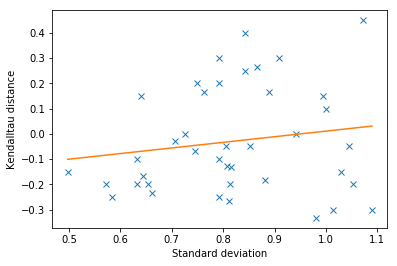

In [695]:
from scipy.stats import linregress
slope, intercept, _, _, _ = linregress(stds[inds], kendalltaus[inds])
plt.plot(stds[inds], kendalltaus[inds], 'x')
plt.plot(stds[inds], stds[inds] * slope + intercept)
plt.xlabel('Standard deviation')
plt.ylabel('Kendalltau distance')
plt.show()

Our method may be influenced by the standard deviation but our sample size of the test set is to small to conclude any statement.